In [42]:
import networkx as nx
import numpy as np
import itertools
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt

## TSP Approximation Algorithms

In [43]:
def christofides_tsp(G):
    MST = nx.minimum_spanning_tree(G)

    OddVertices = [v for v in MST.nodes() if MST.degree(v) % 2 != 0]

    OddGraph = G.subgraph(OddVertices)
    Matching = nx.algorithms.matching.min_weight_matching(OddGraph, weight='weight')

    EulerGraph = nx.MultiGraph()
    EulerGraph.add_edges_from(MST.edges(data=True))
    for u, v in Matching:
        EulerGraph.add_edge(u, v, weight=G[u][v]['weight'])

    EulerTour = list(nx.eulerian_circuit(EulerGraph))
    TSP_Tour = []
    Visited = set()

    for u, v in EulerTour:
        if u not in Visited:
            TSP_Tour.append(u)
            Visited.add(u)

    TSP_Tour.append(TSP_Tour[0])
    return TSP_Tour


def generate_complete_graph(n, seed=42):
    np.random.seed(seed)
    G = nx.complete_graph(n)
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.randint(1, 100)
    return G

## Brute Force TSP

In [44]:
def calculate_total_distance(tour, dist_matrix):
    total_distance = 0
    for i in range(len(tour) - 1):
        total_distance += dist_matrix[tour[i]][tour[i + 1]]
    total_distance += dist_matrix[tour[-1]][tour[0]]  # kết nối điểm cuối với điểm đầu
    return total_distance


def tsp_bruteforce(dist_matrix):
    nodes = list(range(len(dist_matrix)))
    min_distance = float('inf')
    best_tour = None

    for tour in itertools.permutations(nodes):
        total_distance = calculate_total_distance(tour, dist_matrix)
        if total_distance < min_distance:
            min_distance = total_distance
            best_tour = tour

    return best_tour, min_distance

## Branch and Bound TSP

In [45]:
def bound(dist_matrix, curr_path, curr_cost, n):
    bound = curr_cost
    for i in range(len(curr_path) - 1):
        bound += min_edge(dist_matrix, curr_path[i], curr_path[i + 1], n)
    bound += min_edge(dist_matrix, curr_path[-1], curr_path[0], n)
    return bound


def min_edge(dist_matrix, u, v, n):
    min_u = float('inf')
    min_v = float('inf')

    for i in range(n):
        if i != u:
            min_u = min(min_u, dist_matrix[u][i])
        if i != v:
            min_v = min(min_v, dist_matrix[v][i])

    return min_u + min_v


def branch_and_bound(dist_matrix, curr_path, visited, curr_cost, level, n, final_res, final_tour):
    if level == n:
        curr_cost += dist_matrix[curr_path[-1]][curr_path[0]]
        if curr_cost < final_res[0]:
            final_res[0] = curr_cost
            final_tour[0] = curr_path + [curr_path[0]]
        return

    for i in range(n):
        if not visited[i]:
            curr_path.append(i)
            visited[i] = True
            bound_val = bound(dist_matrix, curr_path, curr_cost, n)

            if bound_val < final_res[0]:
                branch_and_bound(dist_matrix, curr_path, visited, curr_cost + dist_matrix[curr_path[-2]][curr_path[-1]],
                                 level + 1, n, final_res, final_tour)

            visited[i] = False
            curr_path.pop()


def solve_tsp(dist_matrix):
    n = len(dist_matrix)
    visited = [False] * n
    visited[0] = True
    curr_path = [0]
    final_res = [float('inf')]
    final_tour = [None]
    branch_and_bound(dist_matrix, curr_path, visited, 0, 1, n, final_res, final_tour)
    return final_tour[0], final_res[0]

## Dynamic Programming TSP

In [46]:

def tsp_dp(dist_matrix):
    n = len(dist_matrix)
    dp = [[float('inf')] * n for _ in range(1 << n)]
    dp[1][0] = 0

    for mask in range(1, 1 << n):
        for u in range(n):
            if (mask & (1 << u)) == 0:
                continue
            for v in range(n):
                if mask & (1 << v):
                    continue
                new_mask = mask | (1 << v)
                dp[new_mask][v] = min(dp[new_mask][v], dp[mask][u] + dist_matrix[u][v])

    final_res = float('inf')
    for i in range(1, n):
        final_res = min(final_res, dp[(1 << n) - 1][i] + dist_matrix[i][0])

    return final_res

In [49]:
# So sánh thời gian chạy của các thuật toán
def compare_algorithms():
    sizes = [x for x in range(3, 12)]
    brute_force_times = []
    branch_and_bound_times = []
    dp_times = []
    christofides_times = []

    for n in sizes:
        print(f"Đồ thị với {n} đỉnh:")

        # Tạo ma trận khoảng cách ngẫu nhiên
        dist_matrix = np.random.randint(1, 100, (n, n))
        for i in range(n):
            for j in range(n):
                if i == j:
                    dist_matrix[i][j] = 0

        G = generate_complete_graph(n)

        # Brute Force
        start_time = time.process_time()
        tsp_bruteforce(dist_matrix)
        end_time = time.process_time()
        brute_force_times.append(end_time - start_time)

        #  Branch and Bound
        start_time = time.process_time()
        solve_tsp(dist_matrix)
        end_time = time.process_time()
        branch_and_bound_times.append(end_time - start_time)

        #  Dynamic Programming
        start_time = time.process_time()
        tsp_dp(dist_matrix)
        end_time = time.process_time()
        dp_times.append(end_time - start_time)

        #Christofides
        start_time = time.process_time()
        christofides_tsp(G)
        end_time = time.process_time()
        christofides_times.append(end_time - start_time)

        print("-" * 40)

    return sizes, brute_force_times, branch_and_bound_times, dp_times, christofides_times


sizes, brute_force_times, branch_and_bound_times, dp_times, christofides_times = compare_algorithms()


Đồ thị với 3 đỉnh:
----------------------------------------
Đồ thị với 4 đỉnh:
----------------------------------------
Đồ thị với 5 đỉnh:
----------------------------------------
Đồ thị với 6 đỉnh:
----------------------------------------
Đồ thị với 7 đỉnh:
----------------------------------------
Đồ thị với 8 đỉnh:
----------------------------------------
Đồ thị với 9 đỉnh:
----------------------------------------
Đồ thị với 10 đỉnh:
----------------------------------------
Đồ thị với 11 đỉnh:
----------------------------------------


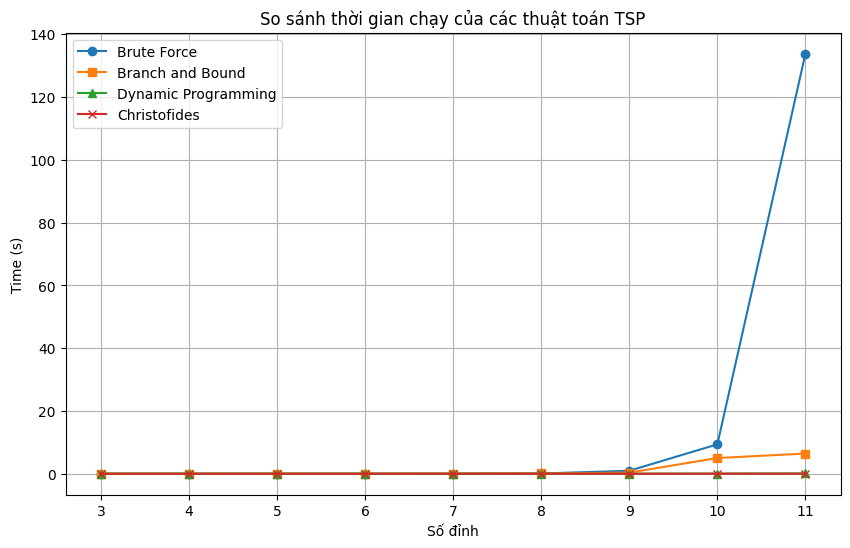

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, brute_force_times, label="Brute Force", marker='o')
plt.plot(sizes, branch_and_bound_times, label="Branch and Bound", marker='s')
plt.plot(sizes, dp_times, label="Dynamic Programming", marker='^')
plt.plot(sizes, christofides_times, label="Christofides", marker='x')

plt.xlabel('Số đỉnh')
plt.ylabel('Time (s)')
plt.title('So sánh thời gian chạy của các thuật toán TSP')
plt.legend()
plt.grid(True)
plt.show()